In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import joblib

In [2]:
sns.set(style='whitegrid')
%matplotlib inline

In [3]:
df = pd.read_csv(r'D:\Documents\DEPI\Walmart_Store_sales.csv')

In [4]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [5]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [6]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['MonthName'] = df['Date'].dt.month_name()
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day,DayOfWeek,MonthName,Is_Weekend
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,5,4,February,0
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,12,4,February,0
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,19,4,February,0
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,26,4,February,0
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,5,4,March,0


In [7]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [8]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [9]:
print(df.describe().T)

               count                 mean                  min  \
Store         6435.0                 23.0                  1.0   
Date            6435  2011-06-17 00:00:00  2010-02-05 00:00:00   
Weekly_Sales  6435.0       1046964.877562            209986.25   
Holiday_Flag  6435.0              0.06993                  0.0   
Temperature   6435.0            60.663782                -2.06   
Fuel_Price    6435.0             3.358607                2.472   
CPI           6435.0           171.578394              126.064   
Unemployment  6435.0             7.999151                3.879   
Year          6435.0          2010.965035               2010.0   
Month         6435.0             6.447552                  1.0   
Week          6435.0            25.818182                  1.0   
Day           6435.0            15.678322                  1.0   
DayOfWeek     6435.0                  4.0                  4.0   
Is_Weekend    6435.0                  0.0                  0.0   

         

In [10]:
missing_values = df.isnull().sum()
missing_values

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Year            0
Month           0
Week            0
Day             0
DayOfWeek       0
MonthName       0
Is_Weekend      0
dtype: int64

In [11]:
df.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Year                     int32
Month                    int32
Week                    UInt32
Day                      int32
DayOfWeek                int32
MonthName               object
Is_Weekend               int64
dtype: object

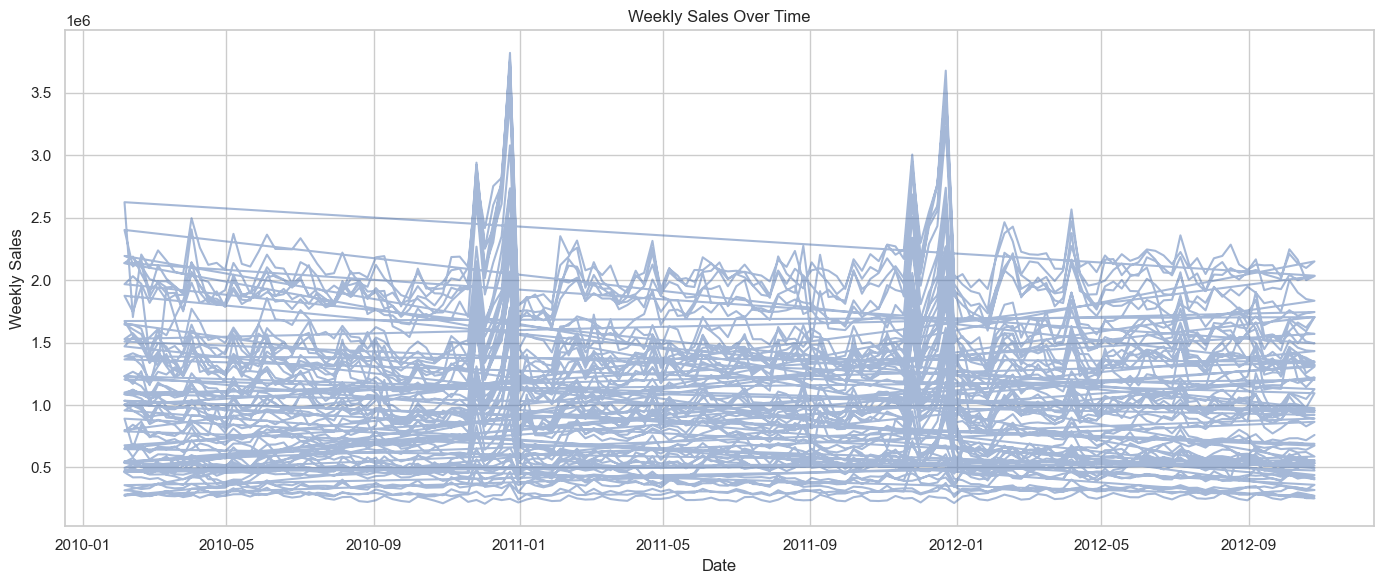

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Weekly_Sales'], alpha=0.5)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

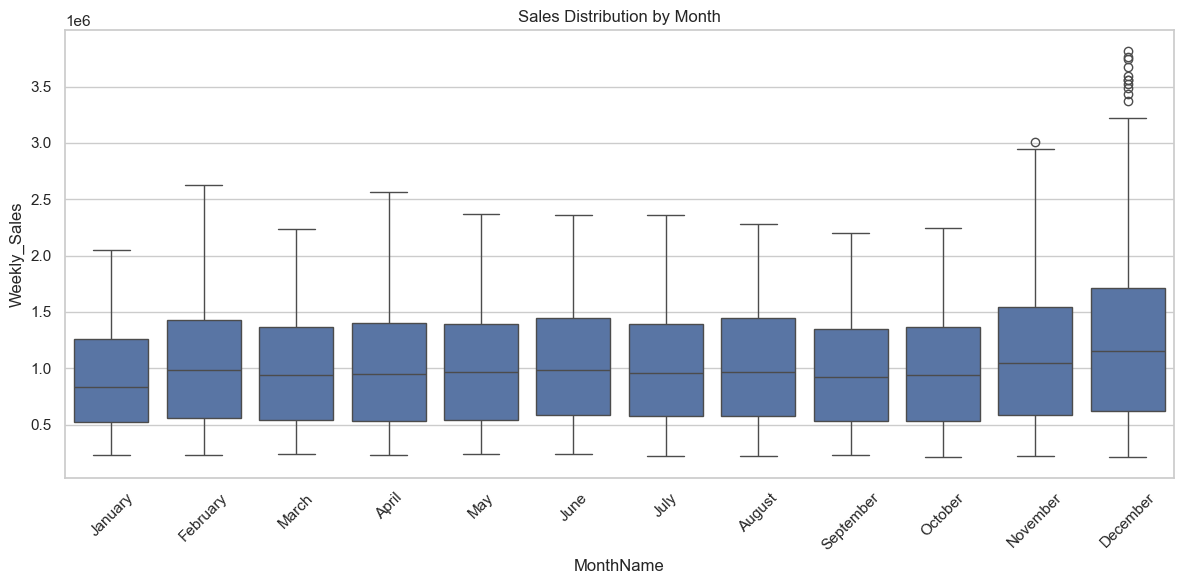

In [13]:
import calendar

plt.figure(figsize=(12,6))
sns.boxplot(x='MonthName', y='Weekly_Sales', data=df, order=list(calendar.month_name)[1:])
plt.title('Sales Distribution by Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

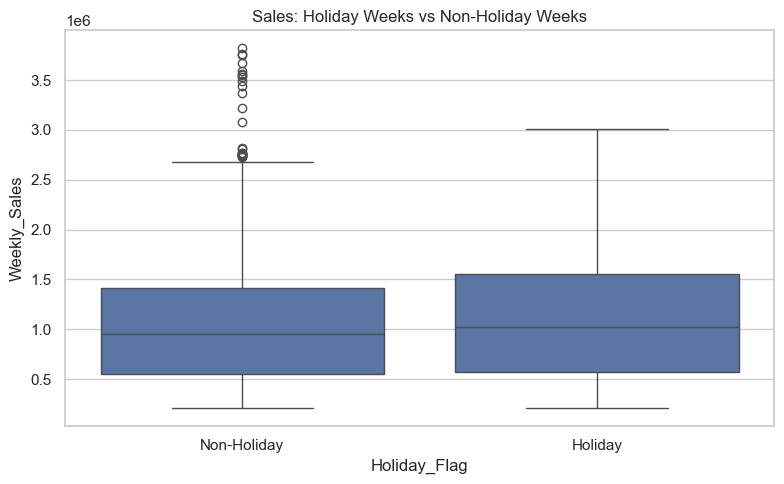

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title('Sales: Holiday Weeks vs Non-Holiday Weeks')
plt.xticks([0,1], ['Non-Holiday', 'Holiday'])
plt.tight_layout()
plt.show()

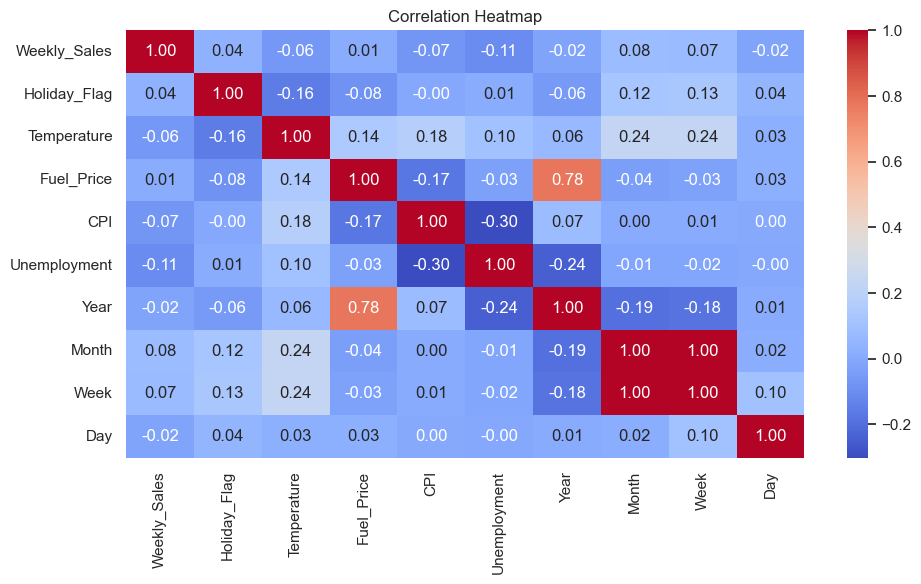

In [15]:
cols_to_drop = ['Store', 'DayOfWeek', 'Is_Weekend']  # Categorical numeric cols
numeric_df = df.select_dtypes(include=[np.number]).drop(cols_to_drop, axis=1)

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()
plt.show()

In [16]:
df.to_csv('Cleaned_Walmart_Store_Sales.csv', index=False)

print("\n✅ Cleaned dataset saved as 'Cleaned_Walmart_Store_Sales.csv'")


✅ Cleaned dataset saved as 'Cleaned_Walmart_Store_Sales.csv'


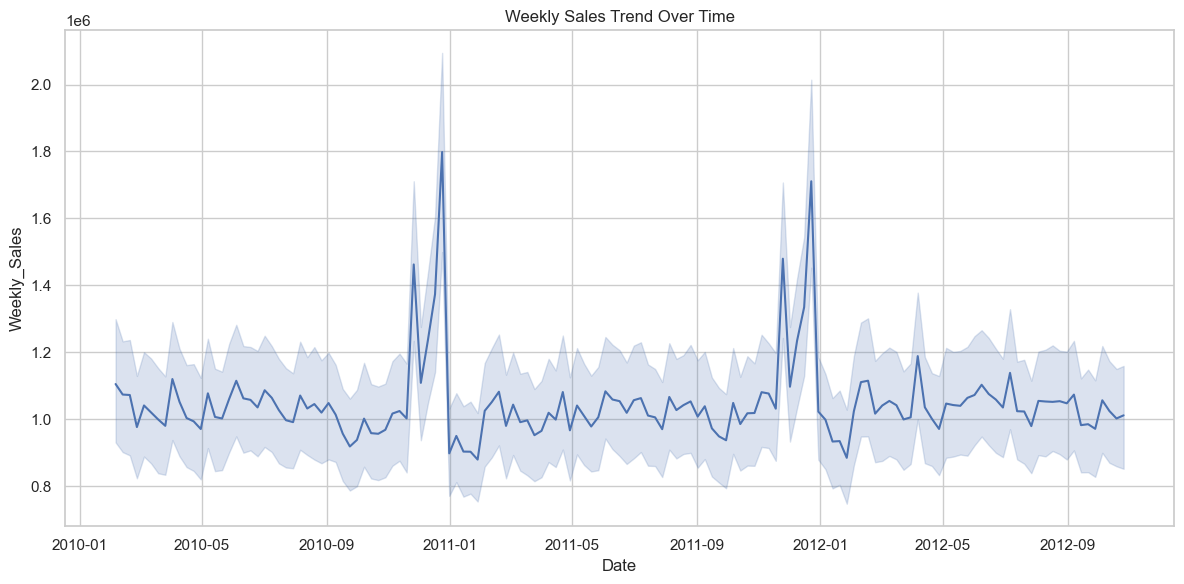

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Weekly_Sales')
plt.title('Weekly Sales Trend Over Time')
plt.tight_layout()
plt.show()

In [18]:
import plotly.io as pio
pio.renderers.default = 'browser'

fig = px.line(df, x='Date', y='Weekly_Sales', color='Store', title='Store-wise Weekly Sales')
fig.show()

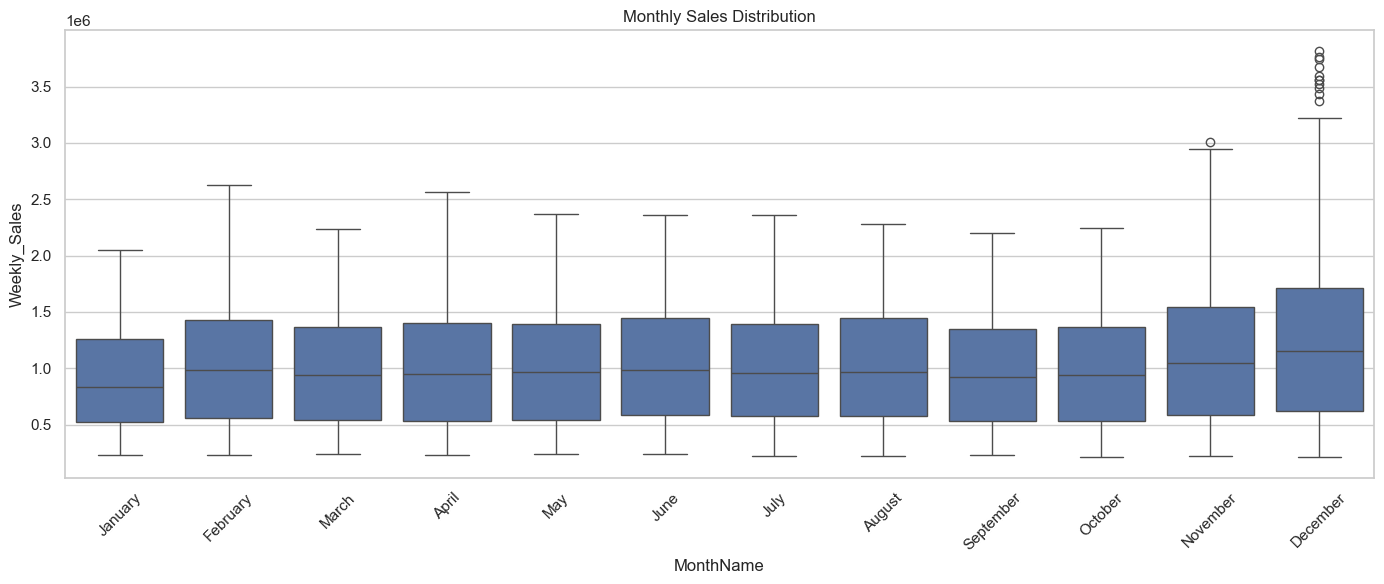

In [19]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='MonthName', y='Weekly_Sales', data=df, order=list(calendar.month_name)[1:])
plt.xticks(rotation=45)
plt.title('Monthly Sales Distribution')
plt.tight_layout()
plt.show()

In [20]:
# Numeric columns: mean or sum; categorical: mode or first value
agg_dict = {
    'Weekly_Sales': 'sum',
    'Holiday_Flag': 'max',   # If any store is holiday, flag whole day/week as holiday
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'Year': 'first',
    'Month': 'first',
    'Week': 'first',
    'Day': 'first',
    'DayOfWeek': 'first',
    'MonthName': 'first',   # could also use mode
    'Is_Weekend': 'first'
}

df_grouped = df.groupby('Date').agg(agg_dict).reset_index()
df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])

In [21]:
df_grouped = pd.get_dummies(df_grouped, columns=['MonthName'])
df_prophet = df_grouped.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

In [22]:
regressors = [c for c in df_prophet.columns if c not in ['ds', 'y']]

In [23]:
model = Prophet()
for reg in regressors:
    model.add_regressor(reg)

model.fit(df_prophet)

03:21:20 - cmdstanpy - INFO - Chain [1] start processing
03:21:20 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
# Create the future dataframe for 52 periods
future = model.make_future_dataframe(periods=52, freq='W')

# Merge or assign future values to each regressor
# For now, let's propagate the last known value forward for numeric features
for reg in regressors:
    if reg in future.columns:
        continue  # Already present, e.g. 'year', 'month' etc.
    if reg in df_prophet.columns:
        last_value = df_prophet[reg].iloc[-1]
        future[reg] = list(df_prophet[reg]) + [last_value]*52

# For generated dummies, repeat as before:
missing_cols = [col for col in df_prophet.columns if col not in future.columns and col.startswith('MonthName_')]
for col in missing_cols:
    last_value = df_prophet[col].iloc[-1]
    future[col] = list(df_prophet[col]) + [last_value]*52

forecast = model.predict(future)

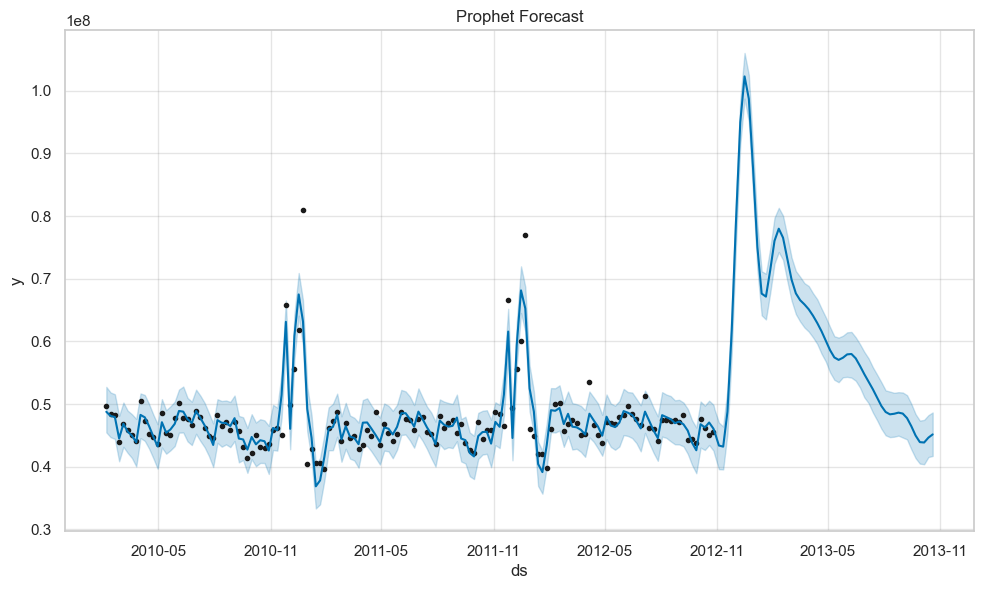

In [25]:
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

In [26]:
actual = df_prophet['y'].values[-52:]
predicted = forecast['yhat'].values[-104:-52]
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

RMSE: 2937271.57, MAE: 1903481.15


In [27]:
np.mean(df_prophet["y"])

47113419.49027973

In [28]:
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 3.74%


In [29]:
# Save the model first 
joblib.dump(model, "prophet_model.pkl")

# Load the model
model = joblib.load("prophet_model.pkl")


In [30]:
import mlflow
import mlflow.pyfunc
import mlflow.prophet

In [31]:
with mlflow.start_run() as run:
    # Log your RMSE, MAE, MAPE
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mape", mape)

    # Log the Prophet model
    mlflow.prophet.log_model(model, artifact_path="model")
    print(f"Model logged in run: {run.info.run_uuid}")

2025/05/13 03:21:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in run: b184e56b6b654330809ec6f15d9cc54a


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import mlflow.sklearn

In [33]:
df_rf = df_grouped.copy()

# Create lag features (example: lags 1, 2, and 3)
for lag in range(1, 4):
    df_rf[f'Weekly_Sales_lag{lag}'] = df_rf['Weekly_Sales'].shift(lag)

# Optionally: lag for other features if you believe past values help predict the future

# Drop NA from lagged rows
df_rf = df_rf.dropna().reset_index(drop=True)

In [34]:
X_cols = [col for col in df_rf.columns if col not in ['Date', 'Weekly_Sales']]
X = df_rf[X_cols]
y = df_rf['Weekly_Sales']


model_rf = RandomForestRegressor(n_estimators=200, random_state=42)
model_rf.fit(X, y)

RandomForestRegressor(n_estimators=200, random_state=42)

In [35]:
import pandas as pd

n_forecast = 52
last_known = df_rf.iloc[-1:].copy()
future_preds = []
future_dates = []

for i in range(n_forecast):
    # Prepare feature row for prediction
    row = last_known[X_cols].iloc[0].copy()  # Make sure 'row' is a Series
    
    # Calculate future date
    future_date = last_known['Date'].iloc[0] + pd.Timedelta(weeks=1)
    future_dates.append(future_date)

    # Update exogenous features as needed
    row['Month'] = future_date.month
    row['Week'] = future_date.isocalendar().week
    row['Day'] = future_date.day
    row['DayOfWeek'] = future_date.dayofweek
    row['Year'] = future_date.year
    row['Is_Weekend'] = int(future_date.dayofweek >= 5)
    
    # Handle month name one-hot encoding
    month_ohe = [col for col in X_cols if col.startswith('MonthName_')]
    row[month_ohe] = 0  # Reset all
    colname = f"MonthName_{future_date.strftime('%B')}"
    if colname in month_ohe:
        row[colname] = 1

    # Ensure row is a DataFrame with a single row and proper col order
    row_df = pd.DataFrame([row], columns=X_cols)
    pred = model_rf.predict(row_df)[0]
    future_preds.append(pred)
    
    # Update last_known for next iteration
    new_last_known = last_known.copy()
    new_last_known['Date'] = future_date

    # Shift lag features and insert the new prediction
    for lag in range(3, 0, -1):
        if lag == 1:
            new_last_known[f'Weekly_Sales_lag{lag}'] = pred
        else:
            new_last_known[f'Weekly_Sales_lag{lag}'] = last_known[f'Weekly_Sales_lag{lag-1}'].values[0]
    last_known = new_last_known.copy()

# Build forecast DataFrame
forecast_rf = pd.DataFrame({
    'Date': future_dates,
    'Weekly_Sales_Pred': future_preds
})

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure your data is sorted by Date
df_rf = df_rf.sort_values('Date').reset_index(drop=True)
test = df_rf.iloc[-52:]    # last 52 weeks as test
test_X = test[X_cols]
test_y = test['Weekly_Sales']

# Predict using the trained random forest model
preds = model_rf.predict(test_X)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(test_y, preds))
mae = mean_absolute_error(test_y, preds)
# Avoid dividing by zero for MAPE
mape = np.mean(np.abs((test_y.values - preds) / (test_y.values + 1e-8))) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1098663.43
MAE: 661827.77
MAPE: 1.29%


In [37]:
# Save the model to a file
joblib.dump(model_rf, "random_forest_model.pkl")

# Load the model from the file
model = joblib.load("random_forest_model.pkl")

In [38]:
# Log to MLflow
with mlflow.start_run() as run:
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("lag", lag)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mape", mape)
    mlflow.sklearn.log_model(model, "model")
    print(f"Model logged in run: {run.info.run_uuid}")

2025/05/13 03:21:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in run: 497423904eab4664ae94cc712893c2e2


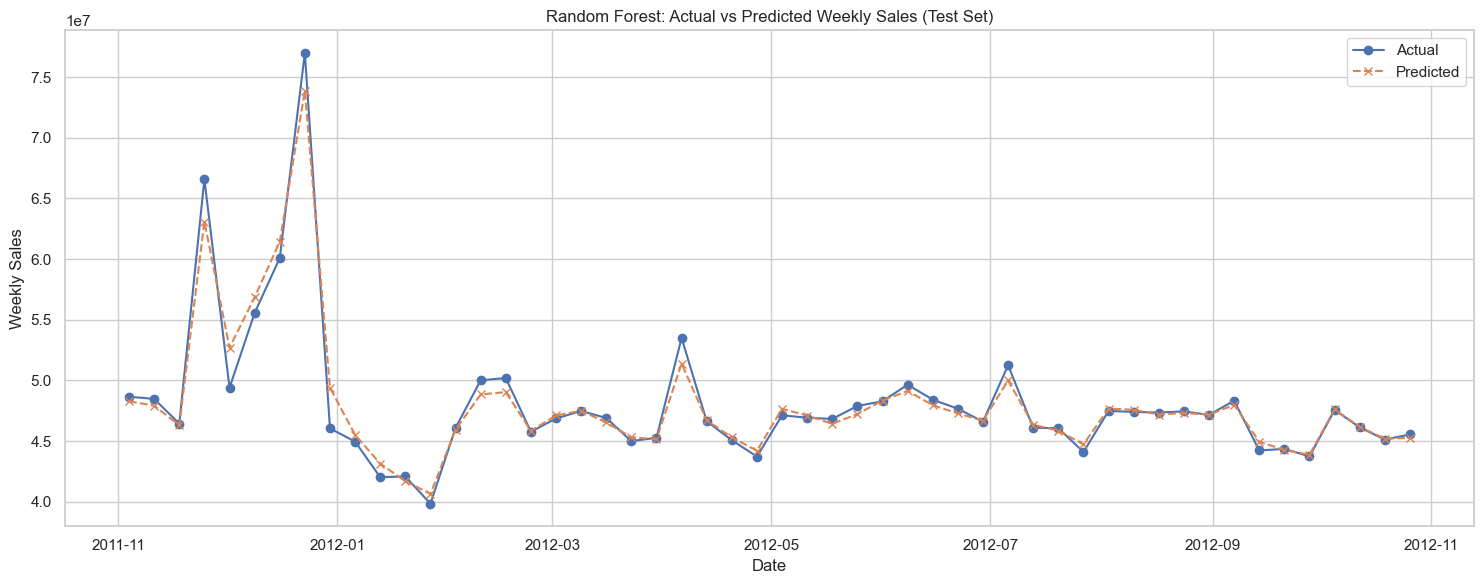

In [39]:
plt.figure(figsize=(15, 6))
plt.plot(test['Date'], test_y, label='Actual', marker='o')
plt.plot(test['Date'], preds, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Random Forest: Actual vs Predicted Weekly Sales (Test Set)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
!C:\Users\abood\AppData\Roaming\Python\Python312\Scripts\mlflow.exe ui
#http://localhost:5000/

In [ ]:
!streamlit run D:\Documents\DEPI\app.py